# Redes totalmente convolucionais

Este notebook aborda os seguintes aspectos relacionados às redes totalmente convolucionais:

- como transformar uma camada densa em convolucional, aproveitando seus pesos;
- como criar, a partir de uma rede pré-treinada para classificar imagens, uma rede totalmente convolucional;
- demonstrar que uma rede totalmente convolucional, quando aplicada em imagens maiores que aquelas usadas em seu treinamento, implementa uma varredura implícita com ganhos de eficiência.
- apresentar um método de supressão de não máximo para detectar caracteres

## Importando os módulos

In [1]:
!pip install matplotlib torch torchvision shapely[vectorized]

    100% |████████████████████████████████| 519.5MB 27kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x585a0000 @  0x7f477c64f2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
    100% |████████████████████████████████| 61kB 20.8MB/s 
    100% |████████████████████████████████| 1.5MB 6.0MB/s 
    100% |████████████████████████████████| 2.0MB 4.0MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
!wget -q https://raw.githubusercontent.com/robertoalotufo/ia368z/master/PyTorch/lib/pytorch_trainer_v2.py -Plib/

In [0]:
%matplotlib inline
import os
import warnings
from collections import OrderedDict

import numpy as np
from shapely import geometry

import matplotlib.pyplot as plt
from matplotlib import patches

import torch
import torch.nn as nn
from torch.utils import data
from torch.optim import lr_scheduler
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# our library
from lib import pytorch_trainer_v2 as ptt

In [4]:
# verifica se a GPU esta disponivel
use_gpu = torch.cuda.is_available()
print("Usando GPU:", use_gpu)
print('CPU Cores:', os.cpu_count())

Usando GPU: True
CPU Cores: 2


## Carregando MNIST dataset

In [0]:
!mkdir data; mkdir data/MNIST

In [6]:
dataset_dir = 'data/MNIST/'

# Transformara os dados em tensores no intervalo [0.0, 1.0] (Os dados serão normalizados)
data_transform = transforms.ToTensor()
# data_transform = None

# carrega o conjunto de treinamento e de teste
datasets_mnist = dict(train=MNIST(dataset_dir, train=True,  transform=data_transform, download=True),
                val  =MNIST(dataset_dir, train=False, transform=data_transform, download=True))

print('Amostras para treinamento:', len(datasets_mnist['train']))
print('Amostras para validação:', len(datasets_mnist['val']))
print(type(datasets_mnist['train'].train_data))
print(datasets_mnist['train'].train_data.size())
print(datasets_mnist['train'].train_data.min(), datasets_mnist['train'].train_data.max())

Processing...
Done!
Amostras para treinamento: 60000
Amostras para validação: 10000
<class 'torch.Tensor'>
torch.Size([60000, 28, 28])
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)


# Definição do dataset com múltiplos dígitos

## Testes iniciais

In [0]:
# Função para criar uma imagem de teste, colocando várias amostras
def make_sample(dataset, M, seed=None):
    if seed is not None:
        np.random.seed(seed)
    N = np.random.randint(5, 8)
    char_index = np.random.choice(len(dataset), N, replace=False)

    # Empty image and outputs
    boxes = []
    image = np.zeros((M, M), np.uint8)
    object_presence_map = np.zeros((M, M), np.int64)
    class_scores_map = -1 * np.ones((M, M), np.int64)
    
    for k, ix in enumerate(char_index):
        img, lab = dataset[ix]
        img *= 255
        img, lab = img.long(), lab.long()
        img, lab = img.numpy(), lab.numpy()
        img = img.reshape(28,28)
        
        # Samples a random position for the digit
        x, y = np.random.randint(0, M-29, size=2)
        digit_box = geometry.box(x, y, x+28, y+28)
        if boxes:
            retries = 0
            skip = False
            # If the digit box intersects with a previous digit, resample
            while any(digit_box.intersects(box) for box in boxes):
                if retries > 10:
                    skip = True
                    break
                x, y = np.random.randint(0, M-29, size=2)
                digit_box = geometry.box(x, y, x+28, y+28)
                retries += 1
            if skip:
                continue
        boxes.append(digit_box)
                
        image[y:y+28, x:x+28] = img
        class_scores_map[y:y+28, x:x+28] = lab
        # Object presence map equals to 1 inside a shrinked bounding box
        object_presence_map[y+10:y+18, x+10:x+18] = 1
        
    # image = image[np.newaxis, ...]
    # object_presence_map = object_presence_map[np.newaxis, ...]
    # class_scores_map = class_scores_map[np.newaxis, ...]
        
    return image, object_presence_map, class_scores_map

In [0]:
def plot_sample(sample):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    img, object_map, class_scores = sample
    # Remove batch_size dims
    # img = img.squeeze(3)
    # object_map = object_map[0]
    # class_scores = class_scores[0]
    
    cax = axs[0].imshow(img, cmap='gray')
    axs[0].set_title('Imagem de entrada')
    # fig.colorbar(ax=axs[0])

    axs[1].imshow(object_map, cmap='gray')
    axs[1].set_title('Mapa de presença de objeto')
    # fig.colorbar(cax)

    cax = axs[2].imshow(class_scores, cmap='rainbow')
    axs[2].set_title('Mapa de classes')
    fig.colorbar(cax)

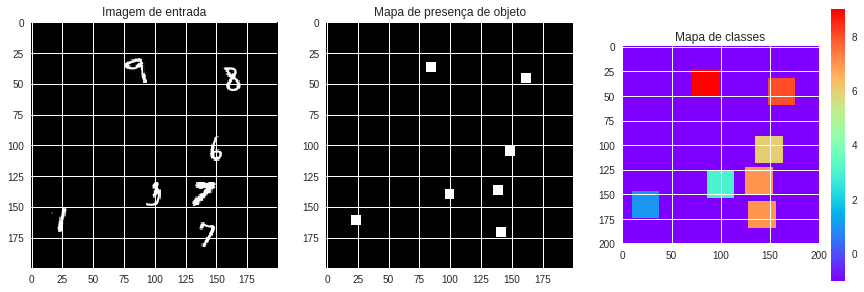

In [9]:
plot_sample(make_sample(datasets_mnist['train'], M=200, seed=9))

In [0]:
class MultiDigitDataset(torch.utils.data.Dataset):
    
    def __init__(self, dataset, image_size=(200, 200), transform=None, length=None, random=False):
        self.dataset = dataset
        self.image_size = image_size
        self.length = length or len(dataset)
        self.random = random
        
        self.transform = transform
        
    def set_length(self, length):
        self.length = length
        
    def __len__(self):
        return self.length
        
    def __getitem__(self, ix):
        seed = ix if not self.random else None
        img, obj_map, cls_map = make_sample(self.dataset, self.image_size[0], seed=seed)
        
        img = img[..., np.newaxis]
        
        if self.transform:
            img = self.transform(img)
        return img, np.dstack((obj_map, cls_map)).transpose(2, 0, 1)

Visualizando shapes, dtypes, valores mínimo e máximo

In [0]:
ds = {
    'train': MultiDigitDataset(datasets_mnist['train'], length=128, random=False),
    'val': MultiDigitDataset(datasets_mnist['val'], length=128, random=False),
}

In [12]:
x, y = ds['train'][0]

obj_map = y[0]
cls_map = y[1]

print('x:', x.shape, x.dtype, x.min(), x.max())
print('obj_map:', obj_map.shape, obj_map.dtype, obj_map.min(), obj_map.max())
print('cls_map:', cls_map.shape, cls_map.dtype, cls_map.min(), cls_map.max())

x: (200, 200, 1) uint8 0 255
obj_map: (200, 200) int64 0 1
cls_map: (200, 200) int64 -1 6


## Definição do modelo com camadas densas (igual ao notebook anterior)

In [0]:
class MyModel(nn.Module):
    
    def make_conv_block(self, in_channels, out_channels, kernel_size=3, padding=1):
        layers = [
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels,
                      kernel_size=kernel_size,
                      padding=padding,
                      bias=False,
                     ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        ]

        return nn.Sequential(*layers)
    
    
    def make_upsample_block(self, in_channels, out_channels):
        layers = [
            nn.Upsample(scale_factor=2,
                        mode='nearest',
                       ),
            nn.ConstantPad2d(padding=(1, 0, 1, 0), # Padding Left, Right, Top, Bottom
                             value=0,
                            ),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels,
                      kernel_size=2,
                      padding=0,
                      bias=False,
                     ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        ]
        return nn.Sequential(*layers)
    
        

    def __init__(self):
        super(MyModel, self).__init__()
        
        self.dropout = nn.Dropout2d()
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Contracting branch
        self.conv1_1 = self.make_conv_block(in_channels=1, out_channels=16, kernel_size=3)
        self.conv1_2 = self.make_conv_block(in_channels=16, out_channels=8, kernel_size=1, padding=0)
        self.conv1_3 = self.make_conv_block(in_channels=8, out_channels=16, kernel_size=3)
        self.conv1_4 = self.make_conv_block(in_channels=16, out_channels=32, kernel_size=3)
        self.conv1_5 = self.make_conv_block(in_channels=32, out_channels=16, kernel_size=1, padding=0)
        self.conv1_6 = self.make_conv_block(in_channels=16, out_channels=32, kernel_size=3)
        
        # Bottleneck
        self.middle_conv_1 = self.make_conv_block(in_channels=32, out_channels=64)
        self.middle_conv_2 = self.make_conv_block(in_channels=64, out_channels=32, kernel_size=1, padding=0)
        self.middle_conv_3 = self.make_conv_block(in_channels=32, out_channels=64)
        
        
        # Expanding branch
        self.upconv_1 = self.make_upsample_block(in_channels=64, out_channels=32)
        self.conv2_1 = self.make_conv_block(in_channels=64, out_channels=32, kernel_size=3)
        self.conv2_2 = self.make_conv_block(in_channels=32, out_channels=16, kernel_size=1, padding=0)
        self.conv2_3 = self.make_conv_block(in_channels=16, out_channels=32, kernel_size=3)
        self.upconv_2 = self.make_upsample_block(in_channels=32, out_channels=16)
        self.conv2_4 = self.make_conv_block(in_channels=32, out_channels=16, kernel_size=3)
        self.conv2_5 = self.make_conv_block(in_channels=16, out_channels=8, kernel_size=1, padding=0)
        self.conv2_6 = self.make_conv_block(in_channels=8, out_channels=16, kernel_size=3)
         
        # Final layer
        # out_channels=12: 
        #    2 channels for object and non-object probability scores)
        #    10 channels for prob scores of the 10 classes
        self.final_conv = nn.Conv2d(in_channels=16, out_channels=12, kernel_size=1, padding=0, bias=True)
        
        
    def forward(self, x):
        
        # print('initial:', x.shape)
        x = self.conv1_1(x)
        x = self.conv1_2(x)
        x_H_1 = self.conv1_3(x)    # H, W
        # print('antes MP1:', x_H_1.shape)
        x = self.max_pool(x_H_1)   # H/2, W/2
        # print(x.shape)
        x = self.conv1_4(x)
        # print(x.shape)
        x = self.conv1_5(x)
        # print(x.shape)
        x_H2_1 = self.conv1_6(x)   # H/2, W/2
        # print('antes MP2:', x_H2_1.shape)
        x = self.max_pool(x_H2_1)  # H/4, W/4
        # x = self.dropout(x)
        # print(x.shape)
        
        x = self.middle_conv_1(x)    # H/4, W/4
        x = self.middle_conv_2(x)
        x = self.middle_conv_3(x)
        # print('middle:', x.shape)

        x_H2_2 = self.upconv_1(x)   # H/2, W/2
        # print('upconv1:', x_H2_2.shape)
        
        x_H2 = torch.cat((x_H2_1, x_H2_2), dim=1)
        # print('cat:', x_H2.shape)
        # x_H2 = self.dropout(x_H2)
        
        x = self.conv2_1(x_H2)
        x = self.conv2_2(x)
        x = self.conv2_3(x)
        # print(x.shape)
        
        x_H_2 = self.upconv_2(x)    # H, W
        # print('upconv2:', x_H_2.shape)
        
        x_H = torch.cat((x_H_1, x_H_2), dim=1)
        # print('cat:', x_H.shape)
        # x_H = self.dropout(x_H)
        
        x = self.conv2_4(x_H)
        x = self.conv2_5(x)
        x = self.conv2_6(x)
        # print('antes final:', x.shape)
        
        y = self.final_conv(x)
        
        # # Object and non-object scores
        # obj_scores = x[:, :2, :, :]
        # # Class scores
        # class_scores = x[:, 2:, :, :]
        
        return y

In [0]:
model = MyModel()

### Testando o shape de saída

In [15]:
warnings.filterwarnings("ignore")
x = torch.randn((1, 1, 200, 200))
y = model(x)
print(y.shape)
print('Input and output have same spatial dimensions?', x.shape[2:] == y.shape[2:])


torch.Size([1, 12, 200, 200])
Input and output have same spatial dimensions? True


## Treinamento com Overfit

### Datasets e DataLoaders

In [0]:
ds = {
    'train': MultiDigitDataset(datasets_mnist['train'],
                               length=16,
                               transform=torchvision.transforms.ToTensor(),
                               random=False),
    'val': MultiDigitDataset(datasets_mnist['val'],
                             length=16,
                             transform=torchvision.transforms.ToTensor(),
                             random=False),
}

dls = {
    'train': data.DataLoader(ds['train'], batch_size=16, num_workers=os.cpu_count(), shuffle=False),
    'val': data.DataLoader(ds['val'], batch_size=16, num_workers=os.cpu_count(), shuffle=False),
}

In [17]:
X, Y = next(iter(dls['train']))

print(X.shape, X.type(), X.min(), X.max())
 
print(Y.shape, Y.type(), Y.min(), Y.max())

torch.Size([16, 1, 200, 200]) torch.FloatTensor tensor(0.) tensor(1.)
torch.Size([16, 2, 200, 200]) torch.LongTensor tensor(-1) tensor(9)


In [18]:
X, Y = next(iter(dls['val']))

print(X.shape, X.type(), X.min(), X.max())

print(Y.shape, Y.type(), Y.min(), Y.max())

torch.Size([16, 1, 200, 200]) torch.FloatTensor tensor(0.) tensor(1.)
torch.Size([16, 2, 200, 200]) torch.LongTensor tensor(-1) tensor(9)


### Trainer

In [0]:
class CombinedLoss(nn.Module):
    
    def __init__(self, obj_presence_weights=[0.05, 5]):
        super().__init__()
        obj_presence_weights = torch.tensor(obj_presence_weights)
        self.CE_obj = nn.CrossEntropyLoss(weight=obj_presence_weights)
        self.CE_cls = nn.CrossEntropyLoss(ignore_index=-1)
        
    def __call__(self, Ypred, Y):
        obj_map = Y[:, 0, :, :]
        cls_map = Y[:, 1, :, :]
        
        obj_map_pred = Ypred[:, :2, :, :]
        cls_map_pred = Ypred[:, 2:, :, :]
        
        obj_loss = self.CE_obj(obj_map_pred, obj_map)
        cls_loss = self.CE_cls(cls_map_pred, cls_map)
        
        return obj_loss + cls_loss


class MyTrainer(ptt.DeepNetTrainer):
    
    def __init__(self, model, lr, devname='cpu', **kwargs):
        self.dev_name = devname
        device = torch.device(self.dev_name)
        
        self.model = model.to(device)
        
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        criterion = CombinedLoss().to(device)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.3)
        
        super().__init__(model,
                         optimizer=optimizer,
                         criterion=criterion,
                         lr_scheduler=scheduler,
                         devname=devname,
                         **kwargs)
    
    
    def _do_optimize(self, X, Y):
        self.optimizer.zero_grad()
        Ypred = self.model.forward(X)
        loss = self.criterion(Ypred, Y)
        loss.backward()
        self.optimizer.step()
        return Ypred, loss

    def _do_evaluate(self, X, Y):
        Ypred = self.model.forward(X)
        loss = self.criterion(Ypred, Y)
        return Ypred, loss

In [0]:
model = MyModel()

In [0]:
cb_chkpt = ptt.ModelCheckpoint('.models/multi_MNIST_v2_overfit', reset=True, verbose=1, load_best=True)

trainer = MyTrainer(model,
                    lr=0.3,
                    devname=0,
                    callbacks = [ptt.PrintCallback(),
                                 cb_chkpt],
                   )

In [0]:
n_epochs = 100
trainer.fit_loader(n_epochs, dls['train'], dls['val'])

## Treinando com dataset maior

In [0]:
ds = {
    'train': MultiDigitDataset(datasets_mnist['train'],
                               length=12800,
                               transform=torchvision.transforms.ToTensor(),
                               random=True),
    'val': MultiDigitDataset(datasets_mnist['val'],
                             length=1280,
                             transform=torchvision.transforms.ToTensor(),
                             random=False),
}

dls = {
    'train': data.DataLoader(ds['train'], batch_size=64, num_workers=os.cpu_count(), shuffle=False),
    'val': data.DataLoader(ds['val'], batch_size=64, num_workers=os.cpu_count(), shuffle=False),
}

In [0]:
model = MyModel()

In [0]:
cb_chkpt = ptt.ModelCheckpoint('.models/multi_MNIST_v2', reset=False, verbose=1, load_best=True)

trainer = MyTrainer(model,
                    lr=0.03,
                    devname=0,
                    callbacks = [ptt.PrintCallback(),
                                 cb_chkpt],
                   )

In [0]:
n_epochs = 10
trainer.fit_loader(n_epochs, dls['train'], dls['val'])

In [0]:
# Load do modelo
trainer.fit_loader(0, dls['train'], dls['val'])

## Avaliação


In [0]:
model = model.eval()

ds['eval'] =  MultiDigitDataset(datasets_mnist['val'],
                               length=12800,
                               transform=torchvision.transforms.ToTensor(),
                               random=True,
                               image_size=(200, 200))

dls = {
    'eval': data.DataLoader(ds['eval'], batch_size=64, num_workers=1, shuffle=False),
}

X, Y = next(iter(dls['eval']))

sample_no = 63
x = X[sample_no:sample_no+1, ...]
y = Y[sample_no, ...]

with torch.no_grad():
    y_pred = model(x.to(0))
y_pred = y_pred.cpu()

x = (x[0][0] * 255).byte()
print(x.shape, x.min(), x.max(), x.type())

In [0]:
obj_map_pred = y_pred[0][:2]
print(obj_map_pred.shape)

cls_map_pred = y_pred[0][2:]
print(cls_map_pred.shape)

In [0]:
obj_map_pred[1].min(), obj_map_pred[1].max()

In [0]:
plot_sample((x, y[0].numpy(), y[1].numpy()))

In [0]:
# Probabilidade de presença de objeto
obj_map_prob = F.softmax(obj_map_pred, dim=0)[1,:,:]
print(obj_map_prob.shape)
# Probabilidade das classes
cls_map_prob = F.softmax(cls_map_pred, dim=0)

max_cls_prob, cls_pred = torch.max(cls_map_prob, dim=0)
print(max_cls_prob.shape)
print(cls_pred.shape)

In [0]:
# mapa de presença de objeto

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(obj_map_prob.numpy(), cmap='gray')
axs[0].set_title('Probabilidade P(obj)')

cax = axs[1].imshow(max_cls_prob.numpy(), cmap='gray')
axs[1].set_title('max(P(classe))')

cax = axs[2].imshow(max_cls_prob.numpy() * obj_map_prob, cmap='gray')
axs[2].set_title('max(P(classe)) * P(obj)')
fig.colorbar(cax)

In [0]:
obj_presence = obj_map_prob.numpy() > 0.5
cls_map = np.where(obj_presence, cls_pred, -1)

plot_sample((x, obj_presence, cls_map))

In [0]:
threshold = 0.75
final_pred = np.where(obj_map_prob > threshold, cls_pred, -1)

plt.imshow(final_pred, cmap='rainbow')
plt.colorbar()

## Tentando implementar non-maximum suppression

In [0]:
def get_boxes(all_cls_probs, p_thresh=0.75):
    boxes = []
    for C in range(10):
        cls_probs = all_cls_probs[C]
        cls_boxes = []
        H, W = cls_probs.shape
        
        i, j = np.unravel_index(np.argsort(cls_probs, axis=None), (H, W))
        
        # Threshold the probs
        sorted_probs = cls_probs[(i, j)]
        th_probs = np.argwhere(sorted_probs > p_thresh)
        if len(th_probs):
            N = th_probs.shape[1]
            i, j = i[-N:], j[-N:]

            # Bboxes de 28x28
            x1 = np.maximum(j-13, 0)
            y1 = np.maximum(i-13, 0)
            x2 = np.minimum(j+14, W)
            y2 = np.minimum(i+14, H)
            p = sorted_probs[-N:]
            cls_boxes = np.stack((x1, y1, x2, y2, p), axis=1)
                    
        boxes.append(cls_boxes)

    return boxes
        
        
# Malisiewicz et al.
# fonte: https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes	
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

### Visualizando

In [0]:
final_cls_probs = cls_map_prob * obj_map_prob

all_boxes = get_boxes(final_cls_probs, p_thresh=0.9)

iou_thresh = 0.3
nms_boxes = [non_max_suppression_fast(boxes, iou_thresh) for boxes in all_boxes]

mean_nms_boxes = [mean_non_max_suppression_fast(boxes, iou_thresh) for boxes in all_boxes]

In [0]:
img = x.numpy().copy()
img = np.dstack((img, img, img))

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(img)
axs[1].imshow(img)

color_list = plt.cm.gist_rainbow(np.linspace(0, 1, 10))

# Todas as bounding boxes
for C in range(10):
    color = color_list[C]
    cls_boxes = all_boxes[C]
    for box in cls_boxes:
        h = box[3] - box[1]
        w = box[2] - box[0]
        patch = axs[0].add_patch(patches.Rectangle(box[:2], w, h, fill=False, edgecolor=color, lw=2))


# Bboxes após NMS

for C in range(10):
    color = color_list[C]
    cls_boxes = nms_boxes[C]
    for box in cls_boxes:
        h = box[3] - box[1]
        w = box[2] - box[0]
        patch = axs[1].add_patch(patches.Rectangle(box[:2], w, h, fill=False, edgecolor=color, lw=2))


## Tentando implementar NMS com média das BBoxes

In [0]:
def mean_non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # mean boxes
    mean_boxes = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    p = boxes[:, 4]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        
        # Calculate the mean box for all overlapping boxes
        box_ixs = np.where(overlap > overlapThresh)[0]
        p_sum = p[last] + p[box_ixs].sum()
        mean_box = p[last] * boxes[last, :4] + np.sum(p[box_ixs][:, np.newaxis] * boxes[box_ixs, :4], axis=0)
        mean_box = mean_box / p_sum
        mean_boxes.append(mean_box)
        
        # delete all indexes from the index list that have
        # been used
        idxs = np.delete(idxs, np.concatenate(([last], box_ixs)))

    return np.round(np.stack(mean_boxes, axis=0)).astype('int')

### Visualizando as bounding boxes para comparar

In [0]:
final_cls_probs = cls_map_prob * obj_map_prob

all_boxes = get_boxes(final_cls_probs, p_thresh=0.9)

iou_thresh = 0.5
nms_boxes = [non_max_suppression_fast(boxes, iou_thresh) for boxes in all_boxes]

mean_nms_boxes = [mean_non_max_suppression_fast(boxes, iou_thresh) for boxes in all_boxes]

In [0]:
img = x.numpy().copy()
img = np.dstack((img, img, img))

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(img)
axs[1].imshow(img)

color_list = plt.cm.gist_rainbow(np.linspace(0, 1, 10))

# Todas as bounding boxes
for C in range(10):
    color = color_list[C]
    cls_boxes = all_boxes[C]
    for box in cls_boxes:
        h = box[3] - box[1]
        w = box[2] - box[0]
        patch = axs[0].add_patch(patches.Rectangle(box[:2], w, h, fill=False, edgecolor=color, lw=2))
        axs[0].set_title('All bboxes')


# Bboxes após NMS

for C in range(10):
    color = color_list[C]
    cls_boxes = nms_boxes[C]
    for box in cls_boxes:
        h = box[3] - box[1]
        w = box[2] - box[0]
        patch = axs[1].add_patch(patches.Rectangle(box[:2], w, h, fill=False, edgecolor=color, lw=2))
        axs[1].set_title('Bboxes after NMS (colored) and Mean NMS (white)')

        

# Bboxes após Mean NMS
for C in range(10):
    color = color_list[C]
    cls_boxes = mean_nms_boxes[C]
    for box in cls_boxes:
        h = box[3] - box[1]
        w = box[2] - box[0]
        patch = axs[1].add_patch(patches.Rectangle(box[:2], w, h, fill=False, edgecolor='white', lw=2))
